In [1]:
%load_ext nbextension
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import dask
import dask.array as da
import dask.dataframe as dd

from gswp.typing import Array
from gswp.constants import GMGSI, PROBSEVERE, MRMS_BOUNDS
MRMS_BOUNDS

(-130, -60, 20, 55)

In [2]:
# FITTING TIME
INTERVAL = 60
TIME_RANGE = 1


def constrain_bounds(
    ds: xr.Dataset, w: float, e: float, s: float, n: float, inplace=False
):
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        lat, lon = ds.lat, ds.lon
        indexers = {
            "lat": lat[(lat > s) & (lat < n)],
            "lon": lon[(lon > w) & (lon < e)],
        }
        return ds.sel(indexers)


def unpack_datetimeindex(*args: np.ndarray):
    for da in args:
        yield pd.to_datetime(da)


def fit_times(
    ps: xr.Dataset, gmgsi: xr.Dataset, interval=INTERVAL, time_range=TIME_RANGE
) -> tuple[xr.Dataset, ...]:
    # normalize the time dtypes by shaving off seconds
    ps["time"] = ps["time"].astype("datetime64[m]")
    gmgsi["time"] = gmgsi["time"].astype("datetime64[m]")

    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        # slice an interval of the probsevere data
        ps.sel(
            time=(pd.to_datetime(ps["time"].to_numpy()).minute % interval) < time_range
        )
        gmgsi_time, ps_time = unpack_datetimeindex(
            gmgsi["time"].to_numpy(), ps["time"].to_numpy()
        )

        return (
            ps.sel(time=ps_time.isin(gmgsi_time)),
            gmgsi.sel(time=gmgsi_time.isin(ps_time)),
        )


PS_DATA, GMGSI_DATA = fit_times(
    PROBSEVERE.load().set_coords("ID"),
    constrain_bounds(GMGSI.load(), *MRMS_BOUNDS),
)

print(
    f"""
PROBSEVERE:
{PS_DATA.to_array().shape=} -> (PARAMETERS, OBSERVATIONS)
{np.unique(PS_DATA.time).shape=} -> (UNIQUE_TIMES,)

GMGSI:
{GMGSI_DATA.to_array().shape=} -> (PARAMETERS, OBSERVATIONS, LONGITUDE, LATITUDE)
{np.unique(GMGSI_DATA.time).shape=} -> (UNIQUE_TIMES,)
"""
)
assert (
    PS_DATA["time"].isin(GMGSI_DATA["time"]).all()
    and GMGSI_DATA["time"].isin(PS_DATA["time"]).all()
)
PS_DATA


PROBSEVERE:
PS_DATA.to_array().shape=(27, 569628) -> (PARAMETERS, OBSERVATIONS)
np.unique(PS_DATA.time).shape=(5001,) -> (UNIQUE_TIMES,)

GMGSI:
GMGSI_DATA.to_array().shape=(3, 5001, 635, 972) -> (PARAMETERS, OBSERVATIONS, LONGITUDE, LATITUDE)
np.unique(GMGSI_DATA.time).shape=(5001,) -> (UNIQUE_TIMES,)



<xarray.Dataset>
Dimensions:            (time: 569628)
Coordinates:
    ID                 (time) uint32 dask.array<chunksize=(30,), meta=np.ndarray>
  * time               (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables: (12/27)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(30,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(30,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    MAXLLAZ            (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>

In [3]:
GMGSI_DATA

<xarray.Dataset>
Dimensions:    (lat: 635, lon: 972, time: 5001)
Coordinates:
  * lat        (lat) float32 20.03 20.1 20.16 20.23 ... 54.86 54.9 54.94 54.98
  * lon        (lon) float32 -130.0 -129.9 -129.8 ... -60.18 -60.11 -60.03
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00

In [4]:
from typing import NewType

_1D = NewType("1d", tuple)


def minimum_diffrence(
    target: np.ndarray[_1D, np.floating],
    values: np.ndarray[_1D, np.floating],
    engine=None,
) -> da.Array | np.ndarray:
    target = target[:, np.newaxis]
    if engine == "dask":
        diff = abs(da.array(target) - da.array(values))
        index = da.argmin(diff, axis=0)
    else:
        diff = abs(target - values)
        index = np.argmin(diff, axis=0)
    return index


features = PS_DATA.copy()

In [5]:
features[["minx", "maxx", "miny", "maxy"]].to_array()

<xarray.DataArray (variable: 4, time: 569628)>
dask.array<stack, shape=(4, 569628), dtype=float32, chunksize=(1, 495), chunktype=numpy.ndarray>
Coordinates:
    ID        (time) uint32 dask.array<chunksize=(30,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
  * variable  (variable) object 'minx' 'maxx' 'miny' 'maxy'

In [6]:
# the indvidual feature extraction is slow so only extracting 3 days
time_slice = slice("2022-07-01", "2022-07-03")

observations = GMGSI_DATA.sel(time=time_slice).compute()

features = PS_DATA.sel(time=time_slice).compute()


assert (
    observations["time"].isin(features["time"]).all()
    and features["time"].isin(observations["time"]).all()
)
features, observations

(<xarray.Dataset>
 Dimensions:            (time: 15229)
 Coordinates:
     ID                 (time) uint32 110697 110999 111202 ... 168222 168223
   * time               (time) datetime64[ns] 2022-07-01 ... 2022-07-03T23:00:00
 Data variables: (12/27)
     CAPE_M10M30        (time) uint32 203 432 460 453 549 ... 377 434 441 592 0
     EBSHEAR            (time) float32 48.1 39.6 12.1 13.1 ... 13.1 8.1 6.3 0.0
     FLASH_DENSITY      (time) float32 0.47 0.23 0.05 0.08 ... 0.0 0.0 0.0 0.0
     FLASH_RATE         (time) uint32 17 9 0 2 1 2 8 12 0 1 ... 0 0 0 0 0 0 0 0 0
     LJA                (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     MAXLLAZ            (time) float32 0.006 0.005 0.002 ... 0.0 0.001 0.001
     ...                 ...
     maxx               (time) float32 -103.2 -109.1 -82.4 ... -79.3 -79.01
     maxy               (time) float32 38.23 40.06 26.96 ... 24.39 24.24 24.14
     minx               (time) float32 -103.3 -109.3 -82.47 ... -79.41 -79.14
     min

In [33]:
# scale the pixle scope of the image extraction
scale_x = 20
scale_y = 20
lat, lon = (np.unique(observations[xy]) for xy in ("lat", "lon"))


minx, maxx, miny, maxy = (
    features[["minx", "maxx", "miny", "maxy"]].to_array().to_numpy()
)

feature_bounds = np.array(
    (
        minimum_diffrence(lat, miny) - scale_y,
        minimum_diffrence(lat, maxy) + scale_y,
        minimum_diffrence(lon, minx) - scale_x,
        minimum_diffrence(lon, maxx) + scale_x,
    )
).T
feature_bounds

array([[268, 311, 350, 392],
       [300, 344, 267, 310],
       [ 84, 125, 639, 680],
       ...,
       [ 44,  85, 620, 660],
       [ 42,  83, 682, 723],
       [ 40,  82, 686, 727]])

In [123]:
arr = observations[["GMGSI_LW", "GMGSI_WV"]].to_array()
PRODUCTS = ...

df = features.to_dataframe()
df[["y1", "y2", "x1", "x2"]] = feature_bounds
df["observation"] = [
    arr.sel(time=t)[PRODUCTS, x1:x2, y1:y2].to_numpy()
    for t, (x1, x2, y1, y2) in zip(df.index, feature_bounds)
]
df = df.set_index("ID", append=True)
df

CAPE_M10M30    EBSHEAR  FLASH_DENSITY  FLASH_RATE  \
time                ID                                                          
2022-07-01 00:00:00 110697          203  48.099998           0.47          17   
                    110999          432  39.599998           0.23           9   
                    111202          460  12.100000           0.05           0   
                    111253          453  13.100000           0.08           2   
                    111347          549  17.900000           0.12           1   
...                                 ...        ...            ...         ...   
2022-07-03 23:00:00 168219          377   8.600000           0.00           0   
                    168220          434  13.100000           0.00           0   
                    168221          441   8.100000           0.00           0   
                    168222          592   6.300000           0.00           0   
                    168223            0   0.000000           0.00           0   

                            LJA  MAXLLAZ  MEANWIND_1-3kmAGL  MESH  MLCAPE  \
time                ID                                                      
2022-07-01 00:00:00 110697  0.0    0.006                7.6  0.23     227   
                    110999  0.0    0.005                9.5  0.32     373   
                    111202  0.0    0.002                3.7  0.04    1730   
                    111253  0.0    0.003               14.2  0.13    1896   
                    111347  0.0    0.007                9.9  0.07    2287   
...                         ...      ...                ...   ...     ...   
2022-07-03 23:00:00 168219  0.0    0.002               12.1  0.00    1401   
                    168220  0.0    0.002               11.1  0.00    1813   
                    168221  0.0    0.000               11.4  0.00    2106   
                    168222  0.0    0.001               13.8  0.06    2257   
                    168223  0.0    0.001                0.0  0.04       0   

                            MLCIN  ...       maxy        minx       miny  \
time                ID             ...                                     
2022-07-01 00:00:00 110697    -58  ...  38.230000 -103.330002  38.020000   
                    110999    -53  ...  40.060001 -109.309998  39.849998   
                    111202    -11  ...  26.959999  -82.470001  26.889999   
                    111253     -4  ...  29.520000  -80.550003  29.190001   
                    111347      0  ...  32.880001  -90.250000  32.790001   
...                           ...  ...        ...         ...        ...   
2022-07-03 23:00:00 168219    -13  ...  25.559999  -81.790001  25.480000   
                    168220     -8  ...  25.190001  -81.620003  25.129999   
                    168221      0  ...  24.389999  -83.900002  24.280001   
                    168222     -2  ...  24.240000  -79.410004  24.139999   
                    168223   -999  ...  24.139999  -79.139999  24.049999   

                                     x          y   y1   y2   x1   x2  \
time                ID                                                  
2022-07-01 00:00:00 110697 -103.254501  38.099998  268  311  350  392   
                    110999 -109.167000  39.950001  300  344  267  310   
                    111202  -82.430000  26.920000   84  125  639  680   
                    111253  -80.464996  29.355000  120  165  666  708   
                    111347  -90.202499  32.834999  178  220  531  573   
...                                ...        ...  ...  ...  ...  ...   
2022-07-03 23:00:00 168219  -81.762497  25.525000   62  103  649  690   
                    168220  -81.589996  25.165001   57   98  651  692   
                    168221  -83.882500  24.334999   44   85  620  660   
                    168222  -79.345001  24.184999   42   83  682  723   
                    168223  -79.070000  24.100000   40   82  686  727   

                                 

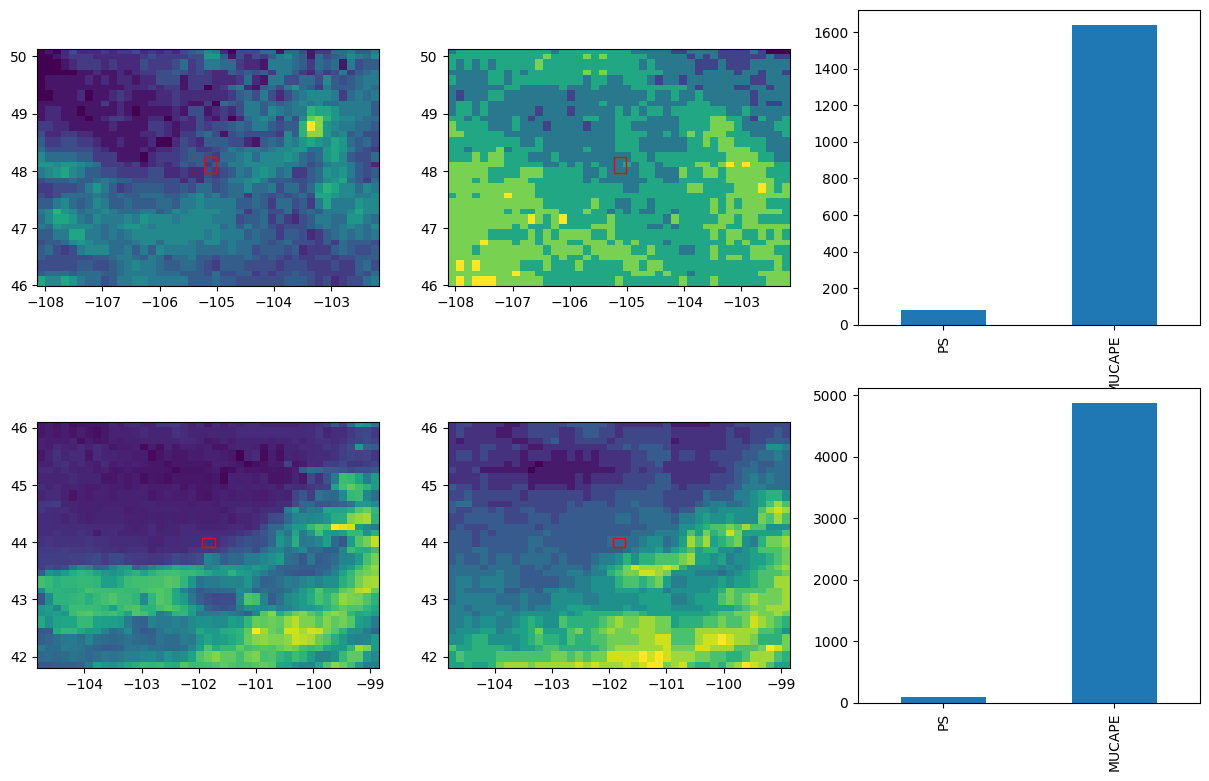

In [140]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

SAMPLE_SIZE = 2


def get_rect(br: np.ndarray, tr: np.ndarray):
    return patches.Rectangle(
        br, *abs(br - tr), linewidth=1, edgecolor="r", facecolor="none"
    )


fig, ax = plt.subplots(nrows=SAMPLE_SIZE, ncols=3)
fig.set_size_inches(15, 9)
for i, ((time, storm_id), s) in enumerate(
    df.loc[df["PS"] > 70].sample(SAMPLE_SIZE).iterrows()
):
    extent = (
        lon[s.x1 - scale_x],
        lon[s.x2 + scale_x],
        lat[s.y1 - scale_y],
        lat[s.y2 + scale_y],
    )
    br = s[["minx", "miny"]].values
    tr = s[["maxx", "maxy"]].values
    rect = patches.Rectangle(
        br, *abs(br - tr), linewidth=1, edgecolor="r", facecolor="none"
    )
    longwave, shortwave = s["observation"]
    ax[i][0].imshow(longwave, extent=extent)
    ax[i][0].add_patch(get_rect(br, tr))
    ax[i][1].imshow(shortwave, extent=extent)
    ax[i][1].add_patch(get_rect(br, tr))
    s[["PS", "MUCAPE"]].plot.bar(ax=ax[i][2])

<xarray.DataArray 'x' ()>
array(nan, dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-03-04

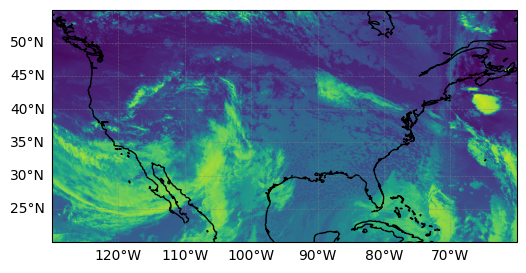

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gswp
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import uuid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes


def axes(projection: ccrs.Projection) -> GeoAxes:
    return plt.axes(projection=projection)


def geoplots(
    num: int | Figure = None,
    projection: ccrs.Projection = ccrs.PlateCarree(),
    figsize: tuple[float, float] = (6, 9),
) -> tuple[Figure, GeoAxes]:
    """
    >>> fig, ax = geoplots()
    """
    fig = plt.figure(num if num else uuid.uuid1(), figsize=figsize)

    ax: GeoAxes = axes(projection=projection)

    gl = ax.gridlines(
        crs=projection,
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )

    gl.top_labels = False

    gl.right_labels = False

    ax.coastlines(resolution="auto")

    return fig, ax


# import gswp.plotting

merged.sel(time=merged.time[0])
merged["GMGSI_LW"].sel(time=merged.time[0])
# plt.imshow(
#     merged["GMGSI_LW"].sel(time=merged.time[0]),
#     extent=MRMS_BOUNDS,
#     # transform=ccrs.PlateCarree(),
# )


fig, ax = geoplots()
first = merged.sel(time=merged.time[0])
first
ax.imshow(first["GMGSI_LW"], extent=MRMS_BOUNDS)
# first
first.x.compute()
# ax.scatter(transform=ccrs.PlateCarree())

In [24]:
a = merged.x.compute()

In [31]:
merged
# a[np.notna(a)]

<xarray.Dataset>
Dimensions:            (time: 5017, lat: 635, lon: 972)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04 ... 2022-09-30T22:00:00
  * lat                (lat) float32 20.03 20.1 20.16 20.23 ... 54.9 54.94 54.98
  * lon                (lon) float32 -130.0 -129.9 -129.8 ... -60.11 -60.03
Data variables: (12/31)
    CAPE_M10M30        (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    FLASH_RATE         (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    ID                 (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    ...                 ...
    miny               (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    GMGSI_LW           (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV           (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS          (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>

In [106]:
ds = merged.loc[{"time": merged["PS"] > 90}]
ds
# ds["GMGSI_LW"]

<xarray.Dataset>
Dimensions:            (time: 0, lat: 635, lon: 972)
Coordinates:
  * time               (time) datetime64[ns] 
  * lat                (lat) float32 20.03 20.1 20.16 20.23 ... 54.9 54.94 54.98
  * lon                (lon) float32 -130.0 -129.9 -129.8 ... -60.11 -60.03
Data variables: (12/31)
    CAPE_M10M30        (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_RATE         (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    ID                 (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                 ...
    miny               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    GMGSI_LW           (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>
    GMGSI_WV           (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>
    GMGSI_VIS          (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>

In [107]:
ds.x

<xarray.DataArray 'x' (time: 0)>
dask.array<getitem, shape=(0,), dtype=float32, chunksize=(0,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns]

In [105]:
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def minimum_diffrence(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index


lat, lon = (da.array(ds[crd]) for crd in ("lat", "lon"))
# arr
ds
arr = da.array(
    [
        minimum_diffrence(lon, ds["minx"]),
        minimum_diffrence(lon, ds["maxx"]),
        minimum_diffrence(lat, ds["miny"]),
        minimum_diffrence(lat, ds["maxy"]),
    ]
).T  # .compute()
minimum_diffrence(lat, ds["minx"]).compute()
# arr.compute()
# x1, y1, y1, y2 = arr
# a = ds["GMGSI_LW"].compute()  # [595:600, 136:140].compute()
# a

array([], dtype=int64)

In [46]:
np.any(~np.isnan(a))

<xarray.DataArray 'GMGSI_LW' ()>
array(False)

In [219]:
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def minimum_diffrence(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index


lat, lon = (da.array(metsat[crd]) for crd in ("lat", "lon"))
# creating a index
arr = da.array(
    [
        minimum_diffrence(lon, PS_DATA["minx"]),
        minimum_diffrence(lon, PS_DATA["maxx"]),
        minimum_diffrence(lat, PS_DATA["miny"]),
        minimum_diffrence(lat, PS_DATA["maxy"]),
    ]
).T
# [x1 for x1, x2, y1, y2 in arr]
# arr#.compute()

KeyboardInterrupt: 

In [68]:
ref_times = GMGSI_DATA["time"].to_numpy()
ref_times

PS_DATA["time"].to_numpy().astype("datetime64[h]")  # $.loc[ref_times]
PS_DATA["time"].to_numpy().astype("datetime64[m]") == PS_DATA["time"].to_numpy()
PS_DATA.sel(
    time=PS_DATA["time"].to_numpy().astype("datetime64[m]").astype("datetime64[s]")
    == PS_DATA["time"].to_numpy().astype("datetime64[s]")
)

<xarray.Dataset>
Dimensions:            (time: 0)
Coordinates:
  * time               (time) datetime64[ns] 
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>

In [107]:
# a = np.unique(PS_DATA.time.astype("datetime64[h]"))
from datetime import timedelta


a = abs(
    PS_DATA["time"].to_numpy().astype("datetime64[h]")
    - PS_DATA["time"].to_numpy().astype("datetime64[s]")
)

x = a < timedelta(seconds=60)
a = PS_DATA.sel(time=x)
ps_hours = np.unique(a.time).astype("datetime64[h]")
print(len(ps_hours))
ps_hours

5012


array(['2022-03-04T00', '2022-03-04T01', '2022-03-04T02', ...,
       '2022-09-30T20', '2022-09-30T21', '2022-09-30T22'],
      dtype='datetime64[h]')

In [128]:
_, index = np.unique(PS_DATA["time"].astype("datetime64[h]"), return_index=True)

PS_DATA.get(dict(time=index))

<xarray.Dataset>
Dimensions:            (time: 5016)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04T00:00:37 ... 2022-09-...
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>

In [113]:
diff = abs(
    GMGSI_DATA["time"].to_numpy().astype("datetime64[s]")[:, np.newaxis]
    - ps_hours.astype("datetime64[s]")
)
sat = GMGSI_DATA.get(
    dict(
        # time=ps_hours.astype("datetime64[s]")
        time=np.unique(np.argmin(diff, axis=0))
    )
)
print(
    f"""
{len(np.unique(ps_hours))}
{len(np.unique(sat.time))}
"""
)


5012
4971



In [5]:
print(
    f"""
{len(np.unique(PS_DATA["time"].astype("datetime64[m]")))=}
{len(GMGSI_DATA["time"])=}"""
)
arr = np.any(
    GMGSI_DATA["time"].to_numpy()[:, np.newaxis].astype("datetime64[m]")
    == PS_DATA["time"].to_numpy().astype("datetime64[m]"),
    axis=1,
)
# arr.time


# len(arr)
# gmgsi = GMGSI_DATA.sel(time=arr)


len(np.unique(PS_DATA["time"].astype("datetime64[m]")))=5019
len(GMGSI_DATA["time"])=5053


AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [37]:
time_diff = GMGSI_DATA["time"].to_numpy()[:, np.newaxis].astype(
    "datetime64[m]"
) == PS_DATA["time"].to_numpy().astype("datetime64[m]")

In [27]:
a = PROBSEVERE.load()
b = GMGSI.load()

In [1]:
from datetime import timedelta

b.time.to_numpy()[:, np.newaxis]

NameError: name 'b' is not defined

In [59]:
df: dd.DataFrame = PS_DATA.to_dask_dataframe()
# df = df.loc[df.time.dt.minute > 2, :]
# df

In [70]:
# len(df), len(df1)
# xr.open_zarr(PROBSEVERE.STORE)
PPS_DATA = PS_DATA.sel(time=PS_DATA.time.dt.minute < 2)
# PS_DATA.sel({"time": pd.to_datetime(PS_DATA.time).minute > 2})

In [ ]:
xr.open_zarr(PROBSEVERE.STORE)

In [3]:
from gswp.constants import MRMS_BOUNDS
import xarray as xr
import dask
import numpy as np
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def constrain_bounds(
    ds: xr.Dataset, w: float, e: float, s: float, n: float, inplace=False
):
    lat, lon = ds.lat, ds.lon
    lat = lat[(lat > s) & (lat < n)]
    lon = lon[(lon > w) & (lon < e)]
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        return ds.sel({"lat": lat, "lon": lon})


def min_diff(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> np.ndarray[dim_1, np.unsignedinteger]:
    diff = abs(target[:, np.newaxis] - values)
    index = np.argmin(diff, axis=0)
    return index


gmgsi = constrain_bounds(SAT_DATA, -130, -60, 20, 55)
gmgsi

<xarray.Dataset>
Dimensions:    (lat: 635, lon: 972, time: 5053)
Coordinates:
  * lat        (lat) float32 20.03 20.1 20.16 20.23 ... 54.86 54.9 54.94 54.98
  * lon        (lon) float32 -130.0 -129.9 -129.8 ... -60.18 -60.11 -60.03
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 635, 4), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00

In [23]:
PS_DATA.sel(
    {
        "time": slice(
            max(SAT_DATA["time"].min(), PS_DATA["time"].min()),
            min(SAT_DATA["time"].max(), PS_DATA["time"].max()),
        )
    }
)
# SAT_DATA

<xarray.Dataset>
Dimensions:            (time: 17127421)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04T00:00:37 ... 2022-09-...
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>

In [4]:
from re import A
import dask.array as da


def dask_min_diff(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index  # .astype(int)


lat, lon = (da.array(gmgsi[crd]) for crd in ("lat", "lon"))

arr = da.array(
    [
        dask_min_diff(lon, PS_DATA["minx"]),
        dask_min_diff(lon, PS_DATA["maxx"]),
        dask_min_diff(lat, PS_DATA["miny"]),
        dask_min_diff(lat, PS_DATA["maxy"]),
    ]
).T
x1, x2, y1, y2 = arr[6000].compute()
x1, x2, y1, y2

(575, 576, 156, 157)

In [6]:
# SAT_DATA.merge(PS_DATA)
# da.array(gmgsi["GMGSI_LW"])[...,x1:x2, y1:y2].compute()
# arr = da.array(
#     [
#         gmgsi["GMGSI_LW"],  # .to_numpy(),
#         gmgsi["GMGSI_VIS"],  # to_numpy(),
#         gmgsi["GMGSI_WV"],  # .to_numpy(),
#     ]
# )
# gmgsi.to_array()
# da.array(lon).compute()

In [117]:
PS_DATA["minx"].compute(), lon

(<xarray.DataArray 'minx' (time: 17139030)>
 array([-79.21, -80.32, -80.95, ..., -74.49, -75.38, -74.3 ], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 2022-03-01T00:00:29 ... 2022-09-30T23:58:41,
 dask.array<array, shape=(1111,), dtype=float32, chunksize=(1111,), chunktype=numpy.ndarray>)

In [53]:
import xarray as xr
from gswp.constants import MRMS_BOUNDS
from typing import TypeVar

T = TypeVar("T")


class Base:
    def __init__(self, data: xr.Dataset) -> None:
        self._data = data

    def to_xarray(self):
        return self._data

    def __repr__(self) -> str:
        return repr(self.to_xarray())

    def _repr_html_(self):
        return self.to_xarray()._repr_html_()

    # def __getattribute__(self: T, __name: str) -> xr.DataArray:
    #     try:
    #         return super().__getattribute__(__name)
    #     except AttributeError:
    #         print(__name)
    #         return self._data[__name]


class ProbSevere(Base):
    _data = PS_DATA

    def fit(self):
        ...


class Metsat(Base):
    _data = SAT_DATA

    @property
    def latitudes(self):
        return self.to_xarray()["lat"].to_numpy()

    @property
    def longitude(self):
        return self.to_xarray()["lon"].to_numpy()

    def constrain_bounds(self, w: float, e: float, s: float, n: float, inplace=False):
        lat, lon = self.latitudes, self.longitude
        lat = lat[(lat > s) & (lat < n)]
        lon = lon[(lon > w) & (lon < e)]
        result = self.to_xarray().sel({"lat": lat, "lon": lon})
        if inplace:
            self._data = result
            return self
        else:
            return Metsat(result)


ps = ProbSevere(PS_DATA)
sat = Metsat(SAT_DATA).constrain_bounds(*MRMS_BOUNDS)

sat

/opt/venv/lib/python3.10/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:    (lat: 2419, lon: 1111, time: 5053)
Coordinates:
  * lat        (lat) float32 -72.74 -72.72 -72.69 -72.67 ... 54.9 54.94 54.98
  * lon        (lon) float32 -59.96 -59.89 -59.82 -59.75 ... 19.82 19.9 19.97
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00